# Unsupervised learning for segmentation of neural timeseries

Author: Ali Zaidi

Date: 09.01.22

### Summary

Here I use an example iEEG recording to demonstrate how to use SVDs for timeseries segmentation on multiple timescales, and to leverage the obtained segments to discover different kinds of neural activity, and improve classification accuracy for events such as epileptic spikes. Using a seizure is convenient as most poeple have some idea of what a seizure is, both clinically and neurophysiologically. This enables a better understanding of the analysis, while also demonstrating it's clinical application. 

**The Data**

The data consists of an iEEG recording with a single seizure flagged by an expert. The seziure begins at 3 minutes (180s) from the start of the recording and ends 3 minutes before the end of the recording. 


**The Analysis**

This tutorial demonstrates the merits of a data-driven approach towards label discovery in unlabeled or noisily labaled datasets. I use a combination of a STFT along with an SVD-GMM to discover multi-scale patterns in the data. This enables the segmentation of the timeseries into events and states, that occur on the scale of milliseconds and seconds respectivily. The states can then be used to discover patterns over the scale of minutes, which can be used to re-discover the seizure period without explicitly being provided any labels.


**The Results**

Using a purely data-driven approach, we discover a 2 minute seizure in the 8 minute long recording, without explicitly being told what a seizure is, obtaining >95% overlap with the original seizure period flagged by an expert. We also obtain events at multiple timescales. For unpsupervised learning, this enables segmentation of the timeseries into a small number of events and states. For clustering, this enables a much better identification of specific events, since it enables the separation of the target neural activity from baseline, as the latter is often interspersed with the former. This enables faster and better classification accuracies.


**Caveats**

The analysis has heuristic elements, mostly in choice of parameters for windowing. A complete and rigorous statistical analysis of the effect of all parameters on the analysis is (sadly) beyond the scope of this tutorial.


This notebook is ideally meant to be read from start to finish, however it has been divided into parts to enable easier reference and navigation.

*The data is from the [ETH iEEG Seizure dataset](http://ieeg-swez.ethz.ch). I'm using the datafile ID1_1.mat here.*

### TL;DR: Jump to the [conclusions](#conclusions) at the very end end.

<br>
Chapters:
<br>

1. [Preprocessing](#preprocessing)
    

2. [STFT decompositon](#stft)
    

3. [SVD of STFT](#svd)
    

4. [GMM based clustering](#gmm)
    

5. [Clustering PSDs into events](#events)
    

6. [Clustering events into states](#states)
    

7. [Clustering: robustness and speed](#clustering)
    

8. [Classification: accuracy and speed](#classification)
    
  
9. [Conclusions](#conclusions)
   

### Definitions

In the analysis, we attempt to identify neural patterns across multiple timescales. A brief summary of definitions of these events are below.

| Name | Definition | scale |
|:---:|:-------:|:-------:|
| Event | A specific distribution over the frequencies of the STFT | sub-seconds (200-500ms) |
| State | A distribution over the events in a timewindow | seconds (10-30s) |
| Theme | A combination of states that is stable for one to several minutes | minutes (1-10 minutes) |

<a id="preprocessing">

## Preprocessing and visualization of data

In [1]:
from __future__ import print_function, absolute_import
import numpy as np
from scipy import signal, fft, io
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
from jupyterthemes import jtplot
jtplot.style()

In [3]:
np.random.seed = 42

In [4]:
data = io.loadmat('../../neuraldatasets/datafiles/eth/EEG_v6.mat')
data = np.array(data['EEG'][:,0])

In [5]:
# high pass filter the data
b, a = signal.butter(10, 200, 'lp', fs=512)
filt_data = signal.filtfilt(b, a, data, method="gust")

In [6]:
dt = np.arange(0, len(data)/512, 1/512)
fs = 512

Text(0.5, 1.0, 'A section of the timeseries showing background and seizure activity')

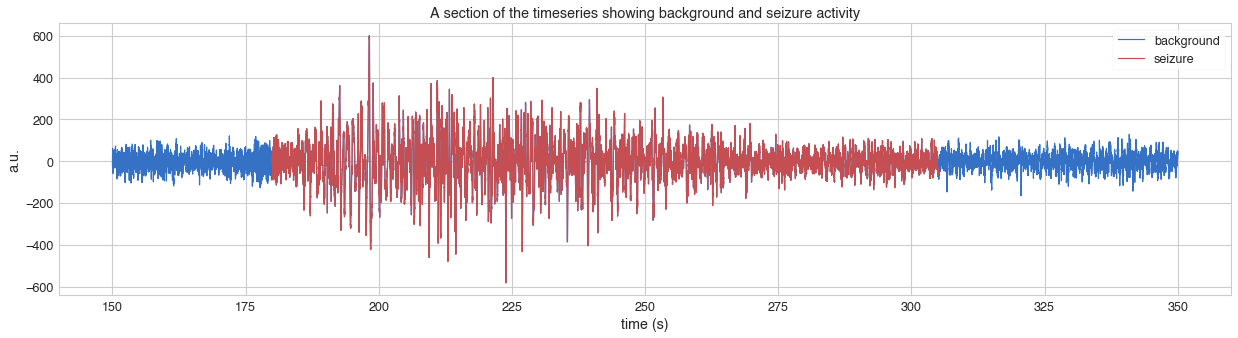

In [7]:
plt.figure(figsize=(21,5));
plt.plot(dt[150*fs:350*fs], filt_data[150*fs:350*fs], label='background');
plt.plot(dt[180*fs:305*fs], filt_data[180*fs:305*fs], 'r', label='seizure');
plt.legend();
plt.xlabel('time (s)'); plt.ylabel('a.u.');
plt.title('A section of the timeseries showing background and seizure activity')

<a id="stft"></a>

## STFT based analysis begins here

We're going to decompose the timeseries using STFT and attempt to cluster the resulting PSDs to obtain events.

In [8]:
nperseg= 500 * 512//1000 # in ms
noverlap= nperseg//4
f, t, ds = signal.stft(filt_data,
                       fs=512,
                       nperseg=nperseg,
                       detrend='constant',
                       padded=True,
                       window='hann')
print(f"nperseg: {nperseg}, overlap:{noverlap}")

nperseg: 256, overlap:64


In [9]:
ds = ds[:,3:-3]
t = t[3:-3]
ds[0,:] = 0
ds_mag = np.abs(ds)
ds_phase = np.arctan(ds.imag,ds.real)

In [10]:
from sklearn.preprocessing import normalize
ds_mag_norm = normalize(ds_mag, norm='l2', axis=0)

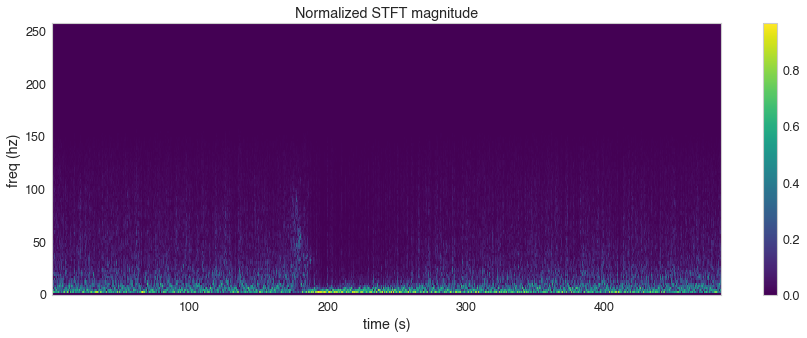

In [11]:
plt.figure(figsize=(15,5));
plt.pcolormesh(t, f, ds_mag_norm);
plt.colorbar();
plt.xlabel('time (s)');
plt.ylabel('freq (hz)');
plt.title('Normalized STFT magnitude');

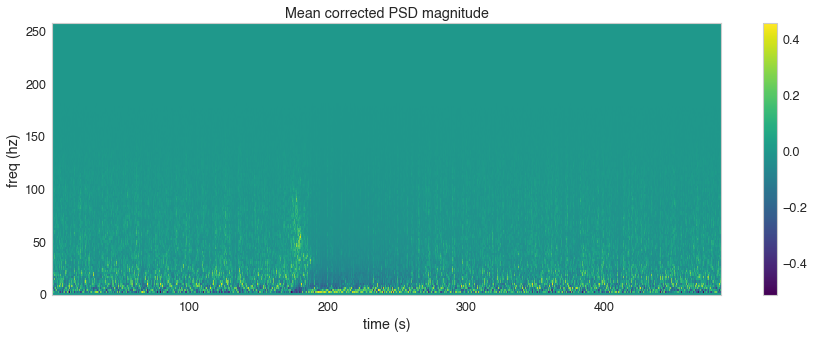

In [12]:
# Remove the mean to enable better visualization and clustering
ds_mean = np.mean(ds_mag_norm, axis=1)
ds_mc = ((ds_mag_norm.T - ds_mean).T).copy()

# Plot the mean-corrected STFT
plt.figure(figsize=(15,5), );
plt.pcolormesh(t, f, ds_mc); plt.colorbar();
plt.xlabel('time (s)');
plt.ylabel('freq (hz)');
plt.title("Mean corrected PSD magnitude");

<a id="svd"></a>

## SVD of DTFT 

Text(0.5, 0, 'Component #')

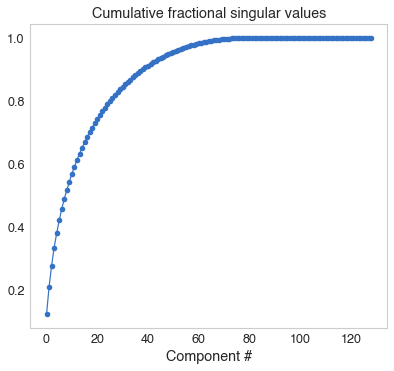

In [13]:
u1, s1, vh1 = np.linalg.svd(ds_mc, full_matrices=False)
plt.plot(np.cumsum(s1)/np.sum(s1), 'o-'); plt.grid();
plt.title('Cumulative fractional singular values');
plt.xlabel('Component #')

ncomps = 26


Text(0.5, 1.0, "V' components")

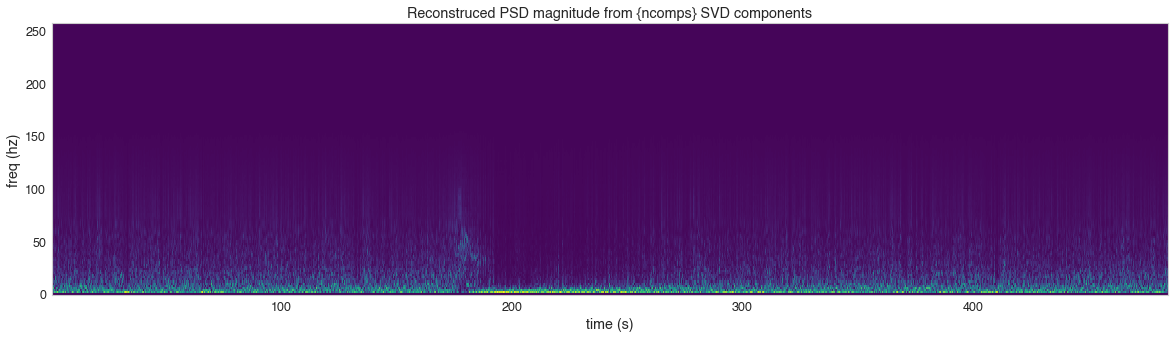

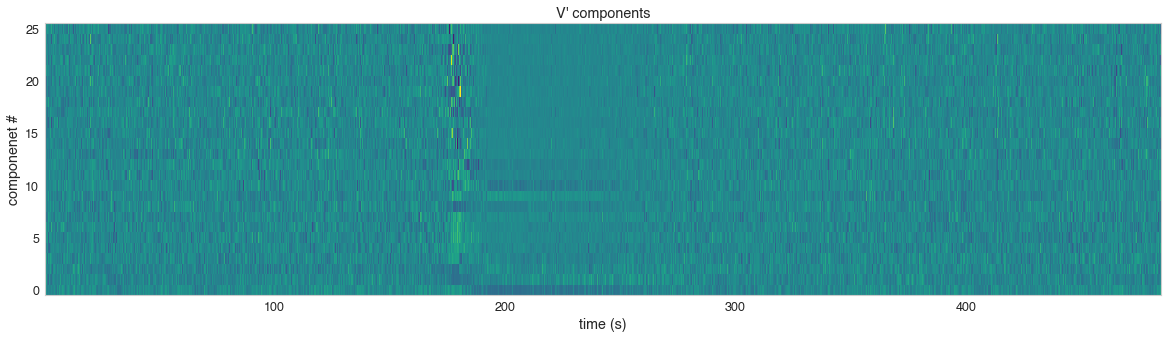

In [14]:
ncomps = np.squeeze(np.where(np.cumsum(s1)/np.sum(s1) >= 0.8))[0]
print(f"ncomps = {ncomps}")

ds_approx_mc = u1[:,:ncomps] @ np.diag(s1[:ncomps]) @ vh1[:ncomps,:]
ds_approx = (ds_approx_mc.T + ds_mean.T).T

plt.figure(figsize=(20,5))
plt.pcolormesh(t, f, ds_approx); plt.xlabel('time (s)'); plt.ylabel('freq (hz)');
plt.title('Reconstruced PSD magnitude from {ncomps} SVD components')
plt.figure(figsize=(20,5))
plt.pcolormesh(t, np.arange(ncomps), vh1[:ncomps,:]);
plt.xlabel('time (s)'); plt.xlabel('time (s)'); plt.ylabel('componenet #'); plt.xticks
plt.title("V' components")

<a id="gmm"></a>

## GMM fit to the data 

We're going to cluster the 'ncomp' components of V'. Using the SVD allows us to specify a diagoncal covariance matrix since all the components are independent from one another and hence have zero correlation. This enables a much faster convergence and allows more robust clustering compared to full covariance matrix.

In [15]:
from sklearn.mixture import BayesianGaussianMixture

In [16]:
nevts_prior=50
bgm = BayesianGaussianMixture(n_components=nevts_prior,
                              max_iter=10**6,
                              covariance_type='diag',
                              n_init=10,
                              random_state=42)

%time bgm.fit(vh1[:ncomps,:].T)
res = bgm.predict(vh1[:ncomps,:].T)

ids, counts = np.unique(res, return_counts=True)
counts = counts/np.sum(counts)

count_filter = np.where(counts>0.01)
ids, counts = ids[count_filter], counts[count_filter]

idx = np.argsort(counts)[::-1]
ids, counts = ids[idx], counts[idx]

nevts = len(ids)

nevts = len(ids)
print(f"Num evts: {nevts}")

evt_labels = np.arange(nevts)

CPU times: user 16.4 s, sys: 554 ms, total: 16.9 s
Wall time: 7.92 s
Num evts: 4


In [17]:
means = (bgm.means_).T
means = means[:, ids]
print("Summary of clustered events:")
for i,v in enumerate(counts):
    print(f"id={i}; freq={counts[i]:0.2f}; num={np.round(counts[i]*len(res))}")

Summary of clustered events:
id=0; freq=0.52; num=1014.0
id=1; freq=0.35; num=685.0
id=2; freq=0.08; num=162.0
id=3; freq=0.04; num=74.0


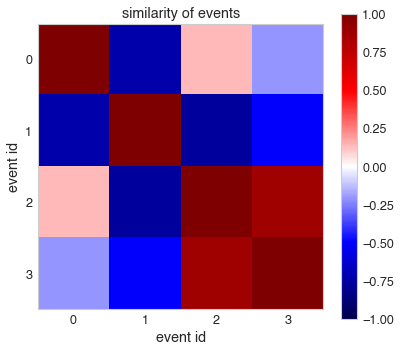

In [18]:
# See how similar the events are to one another using a dot product.

dots = np.zeros((means.shape[1], means.shape[1]))
mean_norm = normalize(means, norm='l2', axis=0, copy=True)
for i in range(means.shape[1]):
    for j in range(means.shape[1]):
        dots[i,j] = np.dot(mean_norm[:,i], mean_norm[:,j])
        
plt.imshow(dots, cmap='seismic'); plt.colorbar(); plt.xticks(range(nevts)); plt.yticks(range(nevts));
plt.xlabel('event id'); plt.ylabel('event id'); plt.title("similarity of events"); plt.clim([-1,1]);
plt.grid(0);

As we can see, there are two groups of events. Events 0 and 1 form one pair, and 2 and 3 form another pair, and the two pairs are quite distinct from one another. 

<a id="events"></a>

## Obtain the mean PSD of each event 

In [19]:
# Obtain the means of the clusters
evt_psd_mc = u1[:,:ncomps] @ np.diag(s1[:ncomps]) @ means
evt_psd = (evt_psd_mc.T + ds_mean).T
# evt_psd_mc, evt_psd = normalize(evt_psd_mc, norm='l2', axis=0), normalize(evt_psd, norm='l2', axis=0)

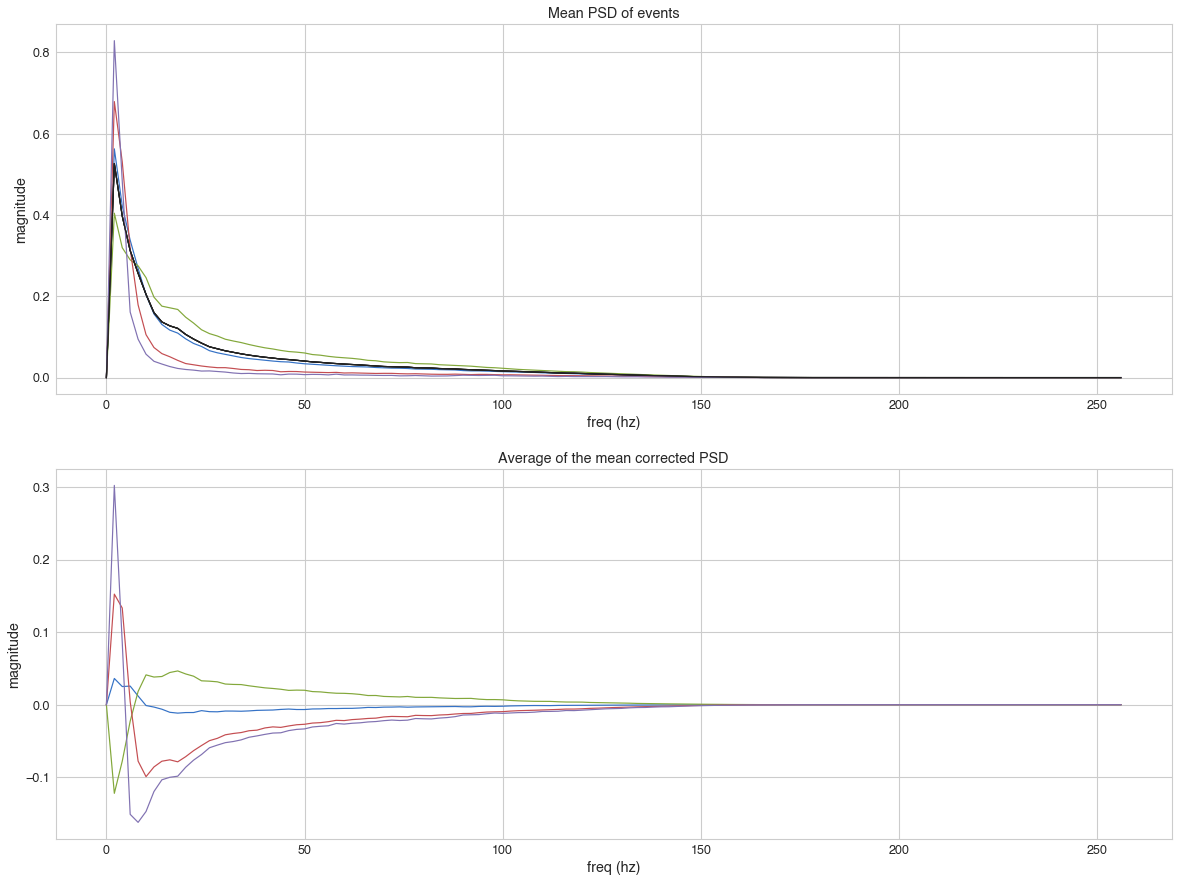

In [20]:
plt.figure(figsize=(20,15))
for i in range(means.shape[1]):
    plt.subplot(2,1,1)
    plt.plot(f, evt_psd[:,i], label=f"evt id:{i}")
    plt.plot(f, ds_mean, 'k', label='overall mean')
    plt.title('Mean PSD of events')
    plt.xlabel('freq (hz)')
    plt.ylabel('magnitude')

    plt.subplot(2,1,2)
    plt.plot(f, evt_psd_mc[:,i])
    plt.xlabel('freq (hz)')
    plt.ylabel('magnitude')
    plt.title('Average of the mean corrected PSD')

## Visualizing the time of various events

In [21]:
res_corrected = np.zeros((res.shape))
for e, i in enumerate(ids):
    idx = res==i
    print(f"converting {sum(idx)} samples from label {i} to {e}")
    
    res_corrected[idx] = e
    
n_events = len(np.unique(res_corrected))

converting 1014 samples from label 9 to 0
converting 685 samples from label 13 to 1
converting 162 samples from label 16 to 2
converting 74 samples from label 4 to 3


In [22]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = res_corrected.reshape(len(res_corrected), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

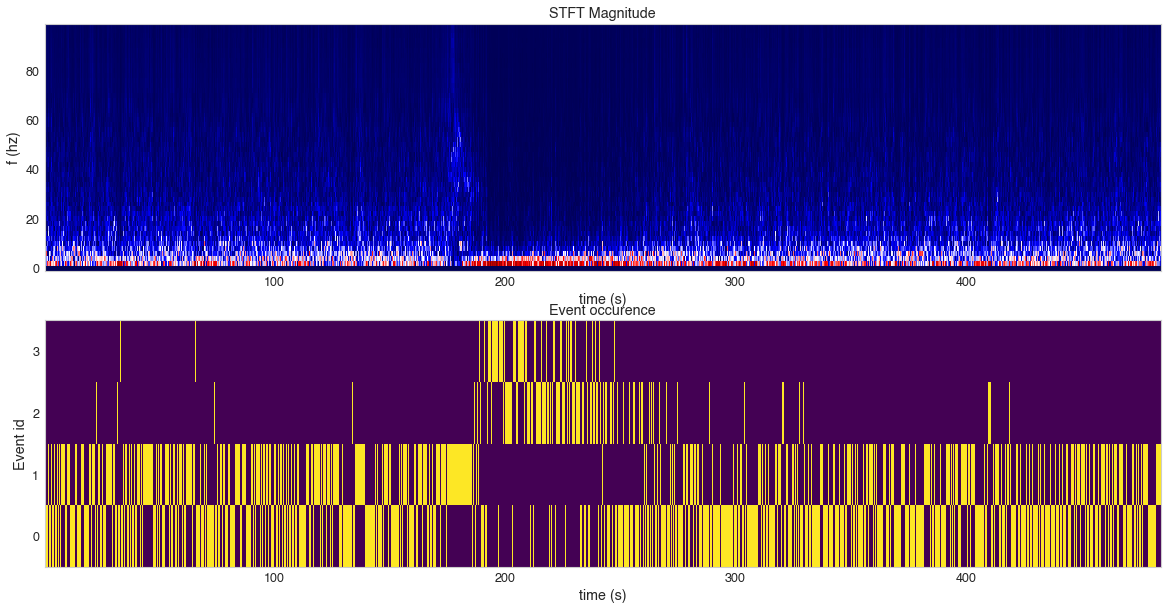

In [23]:
plt.subplots(2,1, figsize=(20,10));

plt.subplot(2,1,1);
plt.pcolormesh(t, f[:50], ds_approx[:50,:], cmap='seismic');
plt.xlabel('time (s)'); plt.ylabel('f (hz)'); plt.title('STFT Magnitude');

plt.subplot(2,1,2);
plt.pcolormesh(t, np.arange(nevts), onehot_encoded.T); plt.yticks(np.arange(nevts));
plt.xlabel('time (s)'); plt.ylabel('Event id'); plt.title('Event occurence');

## Obtaining a transition matrix for the states

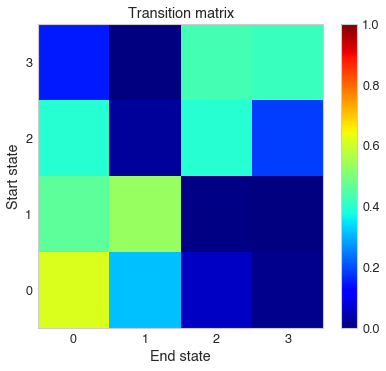

In [24]:
p_prior = np.sum(onehot_encoded, axis=0) / len(res_corrected)

transition = np.zeros((nevts, nevts))
for i in range(nevts):
    idx = np.where(res_corrected[:-1] == i)[0]
    transition[i, :] = np.sum(onehot_encoded.T[:, idx+1], axis=1)
lat_sum = np.sum(transition, axis=1)

for i in range(nevts):
    transition[:,i] = transition[:,i] / lat_sum


plt.pcolormesh(range(nevts), range(nevts), transition, cmap='jet');
plt.colorbar(); plt.clim([0,1])
plt.xticks(np.arange(nevts)); plt.yticks(np.arange(nevts)); 
plt.xlabel('End state');
plt.ylabel('Start state');
plt.title('Transition matrix');

<a id="states"></a>


# Rough estimate of states

#### We can also estimate states from these events, where a state is defined as a timewindow with a specific distribution over all the events.

In [25]:
win_size_seconds = 30
half_win_seconds = win_size_seconds/2

win_size = win_size_seconds * 1000//512
step_size = win_size//4

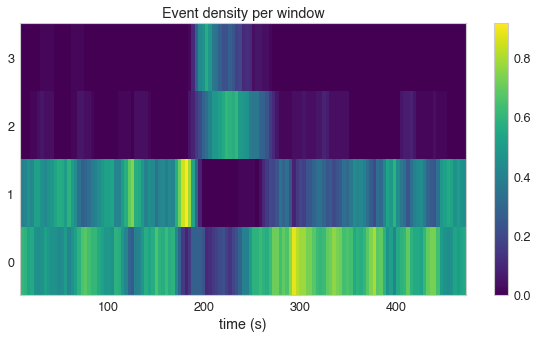

In [26]:
t_steps = np.arange(start=0, stop=len(res_corrected)-win_size, step=step_size)
t_states = np.array(t[t_steps.astype(int)] + 10).astype(int)

evt_aggs = np.empty((nevts, len(t_steps)))
evt_aggs.shape

for i, t_evt in enumerate(t_steps):
    evt_aggs[:,i] = np.mean(onehot_encoded[t_evt:t_evt + win_size,:], axis=0)
    evt_aggs[:,i] /= np.sum(evt_aggs[:,i])
    
evt_aggs = evt_aggs[:,:-1]
t_states = t_states[:-1]
plt.figure(figsize=(10,5))
plt.pcolormesh(t_states[:-1], np.arange(nevts), evt_aggs[:,:-1]); plt.colorbar();
plt.title("Event density per window"); plt.yticks([0,1,2,3]); plt.xlabel('time (s)');

In [27]:
# Cluster the 30s windows
bgm_2 = BayesianGaussianMixture(n_components=evt_aggs.shape[0], n_init=20, max_iter=10**6, covariance_type='full')
%time bgm_2.fit(evt_aggs.T)
print(f"Converged? {bgm_2.converged_}")

state_preds = bgm_2.predict(evt_aggs.T)

state_ids, state_counts = np.unique(state_preds, return_counts=True)
state_counts = state_counts/len(state_preds)

state_means = bgm_2.means_[:,state_ids]
state_means = state_means / np.sum(state_means, axis=0)

# order the states based on their frequency of occurence 
sort_idx = np.argsort(state_counts)[::-1]
state_ids = state_ids[sort_idx]
state_counts = state_counts[sort_idx]

state_preds_corrected = np.zeros(len(state_preds))

for i, id in enumerate(state_ids):
    idx = state_preds == id
    state_preds_corrected[idx] = i
state_ids = np.unique(state_preds_corrected)

CPU times: user 2.51 s, sys: 102 ms, total: 2.62 s
Wall time: 837 ms
Converged? True


Text(0, 0.5, 'event frequency')

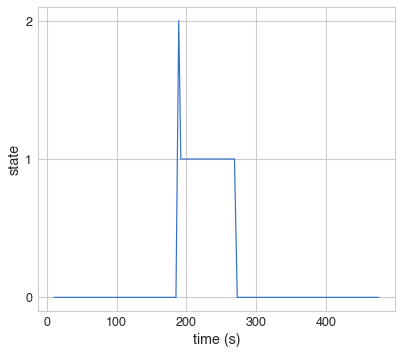

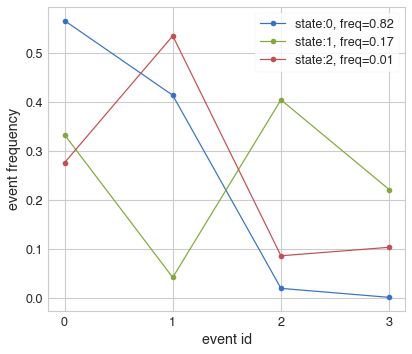

In [28]:
plt.figure();
plt.plot(t_states, state_preds_corrected); plt.xlabel("time (s)"); plt.ylabel("state"); plt.yticks(state_ids);
plt.figure();
for state in state_ids:
    plt.plot(np.mean(evt_aggs[:,state_preds_corrected==state], axis=1),
             marker='o',
             label=f"state:{state.astype(int)}, freq={state_counts[state.astype(int)]:3.2f}");

plt.legend(); plt.xticks(range(nevts)); plt.xlabel("event id"); plt.ylabel("event frequency")

## Non-background activity

In our analysis, we find that state 0 is by far the most common state. However, states 1 and 2 occur during a timewindow of roughly 100s. So if we separate the periods of background (state 0) vs non-background activity, we obtain something close to the original seizure period. Let's see if we can obtain the start and end time of the non-background period from the states...

In [29]:
sz_state_idx = np.where(state_preds_corrected>0)[0]

sz_start = t_states[sz_state_idx[0]] - (half_win_seconds/2)
sz_end  = t_states[sz_state_idx[-1]] + half_win_seconds + 1

# Compare data driven labels with expert marked

real_start = t_states>=180
real_stop = t_states<=305
real_labels = real_start * real_stop

data_start = t_states>=sz_start
data_stop = t_states <= sz_end
data_labels = data_start * data_stop


print(sz_start, sz_end)

181.5 285.0


### This is pretty close to the original labels provided along with the data.

|  | Start (s)| Stop (s)|
|:-------:|:-------:|:----------:|
| Expert: | 180 | 305 |
| Algorithm: | 181.5 | 285 |


#### We discovered a seizure in the data!

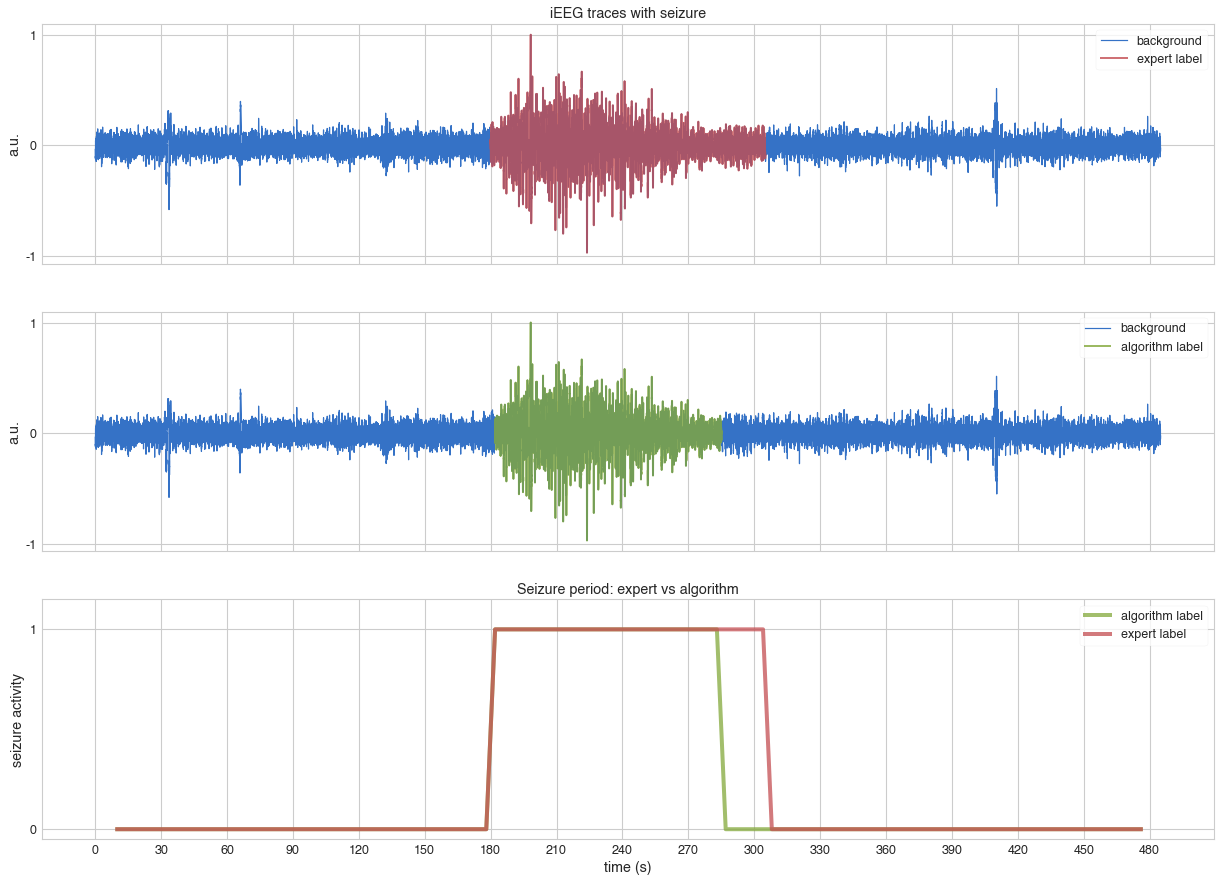

In [52]:
plt.subplots(3,1,sharex=True, figsize=(21,15));
plt.subplot(3,1,1)
plt.plot(dt, filt_data, label='background');
plt.plot(dt[180*fs:305*fs], filt_data[180*fs:305*fs], 'r', linewidth=2, alpha=0.8, label='expert label'); 
plt.legend();  plt.yticks([-600,0,600], labels=[-1,0,1]); plt.ylabel('a.u.');
plt.title('iEEG traces with seizure')


plt.subplot(3,1,2)
plt.plot(dt, filt_data, label='background');
plt.plot(dt[182*fs:285*fs], filt_data[182*fs:285*fs], 'g', linewidth=2, alpha=0.8, label='algorithm label');
plt.legend();  plt.yticks([-600,0,600], labels=[-1,0,1]); plt.ylabel('a.u.');

plt.subplot(3,1,3)
plt.plot(t_states, data_labels, 'g', label="algorithm label", linewidth=4, alpha=0.75);
plt.plot(t_states, real_labels, 'r', label="expert label", linewidth=4, alpha=0.75); 
plt.legend();
plt.xlabel('time (s)'); plt.xticks(np.arange(0, 500, 30));
plt.yticks([0,1]); plt.ylabel('seizure activity'); plt.ylim([-0.05, 1.15]);
plt.title('Seizure period: expert vs algorithm');

In [31]:
acc_labels = np.sum(data_labels == real_labels)/len(real_labels)
print(f"Label overlap = {acc_labels * 100:5.2f}%")

Label overlap = 95.52%


## 95% overlap with original labels

#### Using a data driven approach, we obtain a 95% overlap with the original seziure period that was marked by an expert.

#### In the data-driven approach, the seizure start time is almost identical, but the stop time is 30s early. Generally, it is harder to estimate end times of neural events compared to start times.

## What's the benefit of this approach?

### There are two main advantages: faster computation and robust clustering and classification.

<a id="clustering"></a>

# Assessing improvement in time complexity for clustering

We'll compare using the SVD for clustering (that enables diagonal covariance matrices), versus clustering on the entire PSD obtained per bin of the STFT.

### Starting with the SVD and seeing how robust it is.


Iteration 1 of 5 with prior=5; runtime:
CPU times: user 8.23 s, sys: 288 ms, total: 8.52 s
Wall time: 3.43 s

Iteration 2 of 5 with prior=15; runtime:
CPU times: user 9.1 s, sys: 325 ms, total: 9.42 s
Wall time: 3.3 s

Iteration 3 of 5 with prior=25; runtime:
CPU times: user 13 s, sys: 437 ms, total: 13.4 s
Wall time: 10.2 s

Iteration 4 of 5 with prior=35; runtime:
CPU times: user 13.3 s, sys: 260 ms, total: 13.6 s
Wall time: 4.68 s

Iteration 5 of 5 with prior=45; runtime:
CPU times: user 15.7 s, sys: 775 ms, total: 16.5 s
Wall time: 15.2 s

Total rum time:
CPU times: user 59.4 s, sys: 2.09 s, total: 1min 1s
Wall time: 36.9 s


Text(0.5, 1.0, 'Number of clusters: posterior vs prior')

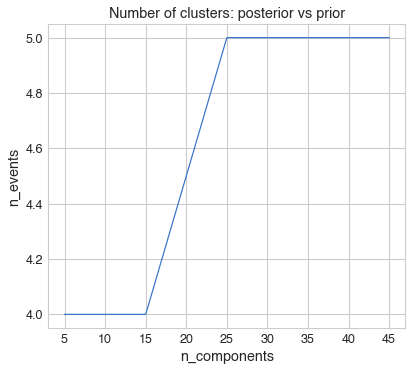

In [32]:
%%time

nevts_priors = np.arange(5, 55, 10)
nevts_post = np.zeros((nevts_priors.shape))

for idx, nevts_prior in enumerate(nevts_priors):
    bgm = BayesianGaussianMixture(n_components=nevts_prior,
                                  max_iter=10**6,
                                  covariance_type='diag',
                                  n_init=10,
                                  random_state=42*idx)

    print(f"\nIteration {idx+1} of {len(nevts_priors)} with prior={nevts_prior}; runtime:")
    %time bgm.fit(vh1[:ncomps,:].T)
    res = bgm.predict(vh1[:ncomps,:].T)

    ids, counts = np.unique(res, return_counts=True)
    counts = counts/np.sum(counts)

    count_filter = np.where(counts*len(ids)>0)
    ids, counts = ids[count_filter], counts[count_filter]

    nevts_post[idx] = len(ids)
print("\nTotal rum time:")
plt.plot(nevts_priors, nevts_post); plt.xlabel("n_components"); plt.ylabel("n_events"); plt.title("Number of clusters: posterior vs prior");

### Compare that to the full PSD of the STFT and see how robust it is to prior specification of n_components

Iteration 1 of 5 with prior=5; runtime:
CPU times: user 1min 42s, sys: 2.13 s, total: 1min 44s
Wall time: 1min
Iteration 2 of 5 with prior=15; runtime:
CPU times: user 1min 2s, sys: 1.87 s, total: 1min 4s
Wall time: 46.6 s
Iteration 3 of 5 with prior=25; runtime:
CPU times: user 1min 10s, sys: 2 s, total: 1min 12s
Wall time: 38.2 s
Iteration 4 of 5 with prior=35; runtime:
CPU times: user 36.8 s, sys: 1.04 s, total: 37.8 s
Wall time: 18.5 s
Iteration 5 of 5 with prior=45; runtime:
CPU times: user 1min 24s, sys: 2.39 s, total: 1min 27s
Wall time: 51.1 s

Total rum time:
CPU times: user 5min 57s, sys: 9.49 s, total: 6min 7s
Wall time: 3min 35s


Text(0.5, 1.0, 'Number of clusters: posterior vs prior')

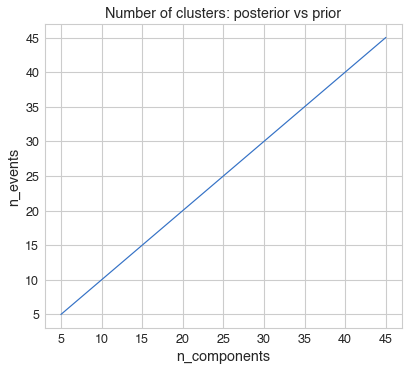

In [33]:
%%time

for idx, nevts_prior in enumerate(nevts_priors):
    bgm = BayesianGaussianMixture(n_components=nevts_prior,
                                  max_iter=10**6,
                                  covariance_type='full',
                                  n_init=10,
                                  random_state=42*idx)

    print(f"Iteration {idx+1} of {len(nevts_priors)} with prior={nevts_prior}; runtime:")
    %time bgm.fit(ds_mag_norm.T)
    res = bgm.predict(ds_mag_norm.T)

    ids, counts = np.unique(res, return_counts=True)
    counts = counts/np.sum(counts)

    count_filter = np.where(counts*len(ids)>0)
    ids, counts = ids[count_filter], counts[count_filter]

    nevts_post[idx] = len(ids)

print("\nTotal rum time:")
plt.plot(nevts_priors, nevts_post); plt.xlabel("n_components"); plt.ylabel("n_events"); plt.title("Number of clusters: posterior vs prior");

<a id="classification"></a>

# Classification of full STFT array vs the components from the SVD decomposition

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, classification_report

In [35]:
# find where the seziure begins (180s into the recording)
print(np.where(t<180)[0][-1])
len(t)//2 

# Only using half of the data for now as sometime in the future I'd like to test on the other half.

716


967

In [36]:
X_full = ds_mag_norm[:,:967].T
y_full = np.zeros((967))
y_full[716:] = 1

full_bacc_scores, full_f1_scores, full_acc_scores = np.zeros((5)), np.zeros((5)), np.zeros((5))

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42*i)

    clf_full = SVC()
    clf_full.fit(X_train, y_train)

    ypred_full = clf_full.predict(X_test)
    full_bacc_scores[i] = balanced_accuracy_score(ypred_full, y_test)
    full_f1_scores[i] = f1_score(ypred_full, y_test)
    full_acc_scores[i] = accuracy_score(ypred_full, y_test)

mean_full_bacc, mean_full_f1, mean_full_acc = np.mean(full_bacc_scores), np.mean(full_f1_scores), np.mean(full_acc_scores)

print("Classification accuracies on full STFT data and the labels in the dataset")
print(f"acc:{mean_full_acc:5.4f}; b_acc:{mean_full_bacc:5.4f}; f1_score:{mean_full_f1:5.4f}")

mean_full_scores = [mean_full_acc, mean_full_bacc, mean_full_f1]

Classification accuracies on full STFT data and the labels in the dataset
acc:0.9072; b_acc:0.9050; f1_score:0.8095


In [37]:
X_svd = vh1[:ncomps,:967].T

res_binary=np.zeros((res_corrected.shape))
idx_evts = np.squeeze(np.where(res_corrected>2))
res_binary[idx_evts] = 1
y_svd = res_binary[:967]

svd_bacc_scores, svd_f1_scores, svd_acc_scores = np.zeros((5)), np.zeros((5)), np.zeros((5))

for i in range(5):

    X_train, X_test, y_train, y_test = train_test_split(X_svd, y_svd, test_size=0.2, random_state=42*i)

    clf_svd = SVC()
    clf_svd.fit(X_train, y_train)
    ypred_svd = clf_svd.predict(X_test)
    
    svd_acc_scores[i] = accuracy_score(ypred_svd, y_test)
    svd_bacc_scores[i] = balanced_accuracy_score(ypred_svd, y_test)
    svd_f1_scores[i] = f1_score(ypred_svd, y_test)

mean_svd_bacc, mean_svd_f1, mean_svd_acc = np.mean(svd_bacc_scores), np.mean(svd_f1_scores), np.mean(svd_acc_scores)

print("Classification accuracies on SVD data and the labels obtained by timeseries segmentation.")
print(f"acc:{mean_svd_acc:5.4f}; b_acc:{mean_svd_bacc:5.4f}; f1_score:{mean_svd_f1:5.4f}")

mean_svd_scores = [mean_svd_acc, mean_svd_bacc, mean_svd_f1]

Classification accuracies on SVD data and the labels obtained by timeseries segmentation.
acc:0.9938; b_acc:0.9967; f1_score:0.9463


In [38]:
cross_bacc_scores, cross_f1_scores, cross_acc_scores = np.zeros((5)), np.zeros((5)), np.zeros((5))

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_svd, test_size=0.2, random_state=42*i)

    clf_cross = SVC()
    clf_cross.fit(X_train, y_train)

    ypred_full = clf_cross.predict(X_test)
    cross_bacc_scores[i] = balanced_accuracy_score(ypred_full, y_test)
    cross_f1_scores[i] = f1_score(ypred_full, y_test)
    cross_acc_scores[i] = accuracy_score(ypred_full, y_test)

mean_cross_bacc, mean_cross_f1, mean_cross_acc = np.mean(cross_bacc_scores), np.mean(cross_f1_scores), np.mean(cross_acc_scores)
print(f"acc:{mean_cross_acc:5.4f};\tb_acc:{mean_cross_bacc:5.4f};\tf1_score:{mean_cross_f1:5.4f}")
mean_cross_scores = [mean_cross_acc, mean_cross_bacc, mean_cross_f1]

acc:0.9856;	b_acc:0.9667;	f1_score:0.8950


In [39]:
cross2_bacc_scores, cross2_f1_scores, cross2_acc_scores = np.zeros((5)), np.zeros((5)), np.zeros((5))

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_svd, y_full, test_size=0.2, random_state=42*i)

    clf_cross2 = SVC()
    clf_cross2.fit(X_train, y_train)

    ypred_full = clf_cross2.predict(X_test)
    cross2_bacc_scores[i] = balanced_accuracy_score(ypred_full, y_test)
    cross2_f1_scores[i] = f1_score(ypred_full, y_test)
    cross2_acc_scores[i] = accuracy_score(ypred_full, y_test)

mean_cross2_bacc, mean_cross2_f1, mean_cross2_acc = np.mean(cross2_bacc_scores), np.mean(cross2_f1_scores), np.mean(cross2_acc_scores)
print(f"acc:{mean_cross2_acc:5.4f};\tb_acc:{mean_cross2_bacc:5.4f};\tf1_score:{mean_cross2_f1:5.4f}")
mean_cross2_scores = [mean_cross2_acc, mean_cross2_bacc, mean_cross2_f1]

acc:0.9216;	b_acc:0.9245;	f1_score:0.8411


Text(0, 0.5, 'score')

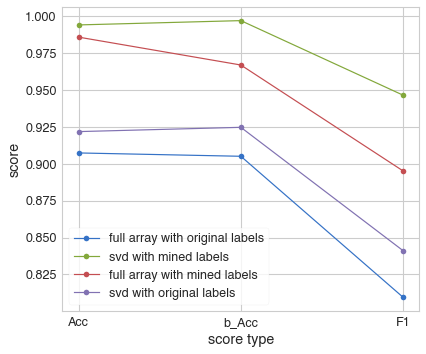

In [40]:
plt.plot(mean_full_scores, 'o-', label="full array with original labels")
plt.plot(mean_svd_scores, 'o-', label="svd with mined labels")
plt.plot(mean_cross_scores, 'o-', label="full array with mined labels")
plt.plot(mean_cross2_scores, 'o-', label="svd with original labels")

plt.legend()
plt.xticks(range(3), ['Acc', 'b_Acc', 'F1']); plt.xlabel('score type'); plt.ylabel('score')

In [41]:
red_acc = ((1-mean_full_acc) - (1-mean_svd_acc))/(1-mean_full_acc)
red_bacc = ((1-mean_full_bacc) - (1-mean_svd_bacc))/(1-mean_full_bacc)
red_f1 = ((1-mean_full_f1) - (1-mean_svd_f1))/(1-mean_full_f1)

print(f"reduction in error: acc={red_acc*100:3.1f}%, b_acc={red_bacc*100:3.1f}%, f1_score:{red_f1*100:3.1f}%")

reduction in error: acc=93.3%, b_acc=96.6%, f1_score:71.8%


<a id="conclusions"></a>

# Conclusions

To enable a better understanding of the neural timeseries, we attemped to identify different events at different timescales. 

1. Decomposing the STFT data using SVD enables much more robust event detection, and is markedly faster than using the PSD itself (takes only 10% of the time)!
    
2. Using the segmented timeseries to obtain labels for the target is far more effective than using a larger temporal window. This is because the labels provided are composed of a mixture of multiple events, i.e. both seizure and non-seizure activity.


**We re-discovered the seizure period in the data, that overlaps with the expert-provided labels by over 95%**
        
**Data-driven labels enable a balanced accuracy score of ~99.7%, and a reduction of ~97% in the misclassification rate between seizure and non-seizure activity!**

### Bottom line: 

### For unsupervised segmentation: reduction in clustering time by ~86%; robust to model priors.

### For classification: reduction in misclassification rate by ~97%